In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
##Reading the training images for training SVM
import glob
import cv2
import numpy as np
import matplotlib.image as matimg
from sklearn.utils import shuffle
carImages=glob.glob('training-data/vehicles/**/*.png')
notcarimages=glob.glob('training-data/non-vehicles/**/*.png')
XTrainImage=[]
y=[]
for image in carImages:
    image=matimg.imread(image)
    XTrainImage.append(image)
    y.append([1])
for image in notcarimages:
    image=matimg.imread(image)
    XTrainImage.append(image)
    y.append([0])
XTrainImage=np.array(XTrainImage)
y=np.array(y)
XTrainImage, y=shuffle(XTrainImage,y)

D:\anaconda\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


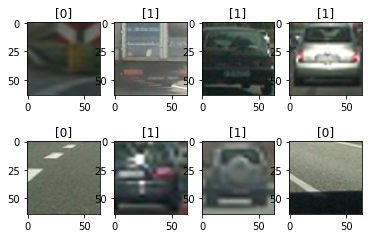

In [6]:
##Visualizing Random Car and non-car images
import matplotlib.pyplot as plt
f, ax = plt.subplots(2,4)
for i in range(2):
    for j in range(4):
        index=np.random.randint(0,XTrainImage.shape[0])
        ax[i,j].imshow(XTrainImage[index,:,:,:])
        ax[i,j].set_title(y[index])

In [7]:
##Extracting the HOG features
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

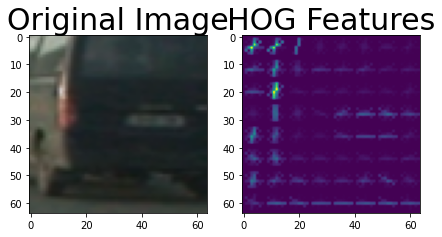

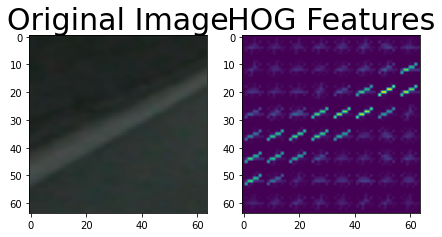

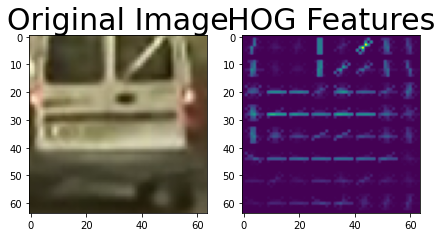

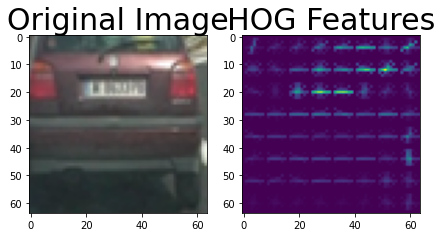

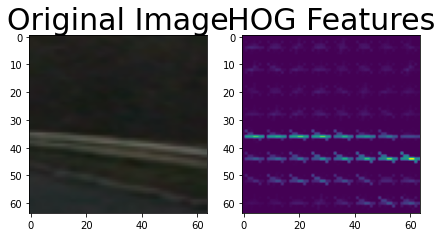

In [8]:
for i in range(0,5):
    index=np.random.randint(0,XTrainImage.shape[0])
    test_img=XTrainImage[index,:,:,:]
    features,test_dst_image= get_hog_features(test_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
    ax1.imshow(test_img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(test_dst_image)
    ax2.set_title('HOG Features', fontsize=30)

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs: 
        # Read in each one by one
        #image = matimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feat_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feat_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feat_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feat_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feat_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feat_image = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_feat = []
            for channel in range(feat_image.shape[2]):
                hog_feat.append(get_hog_features(feat_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_feat = np.ravel(hog_feat)        
        else:
            hog_feat = get_hog_features(feat_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_feat)
    # Return list of feature vectors
    return features

In [10]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
y_start_stop = [None, None] # Min and max in y to search in slide_window()

features = extract_features(list(XTrainImage), color_space=color_space,  
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel='ALL')
features=np.array(features)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(features, y, test_size=0.2)
#from sklearn.preprocessing import StandardScaler
#scaler=StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.transform(X_test)

In [12]:
##Training the SVM with default parameters
from sklearn.svm import LinearSVC
svc=LinearSVC()
svc.fit(X_train,y_train)
print(svc.score(X_test, y_test))

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9692832764505119


In [13]:
def findcar(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False) 
    rectangle=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print(hog_feat.reshape(1,-1).shape)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Scale features and make a prediction
            hog_feat=hog_feat.reshape(1,-1)
            #test_features = scaler.transform(hog_feat)
            #test_features = scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            testpredict = svc.predict(hog_feat)
            
            if testpredict == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangle.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return rectangle


In [14]:
def draw_boxes(img, bboxes, color=(0, 255, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0],bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

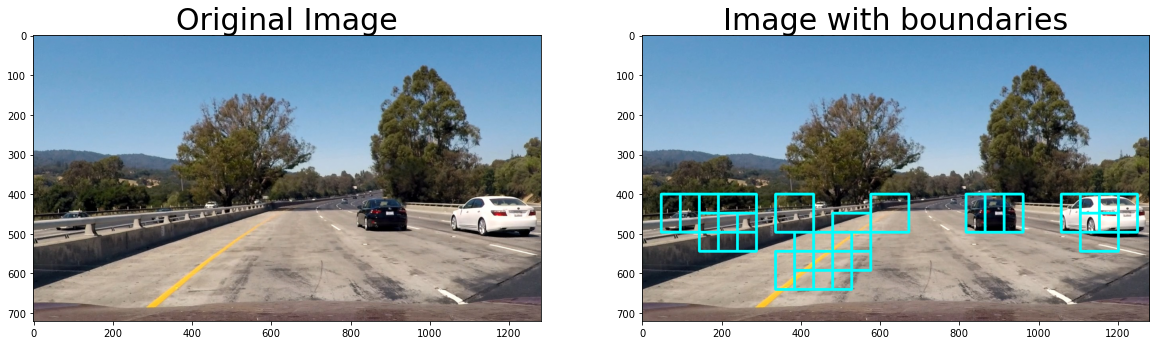

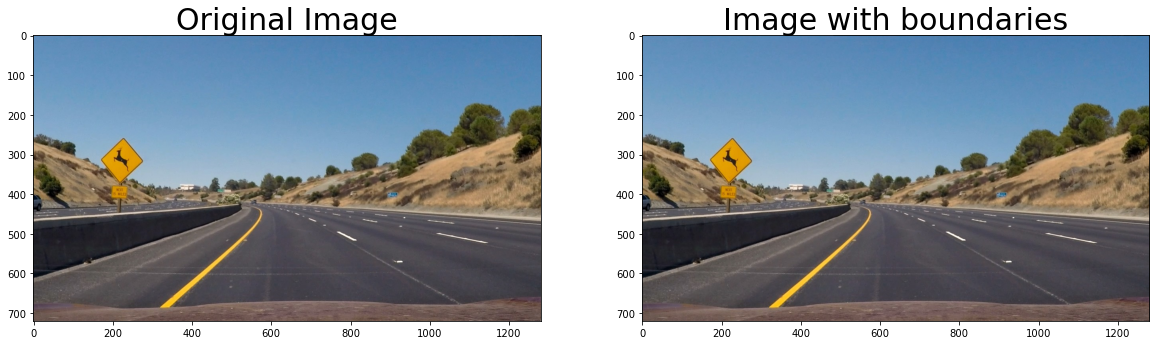

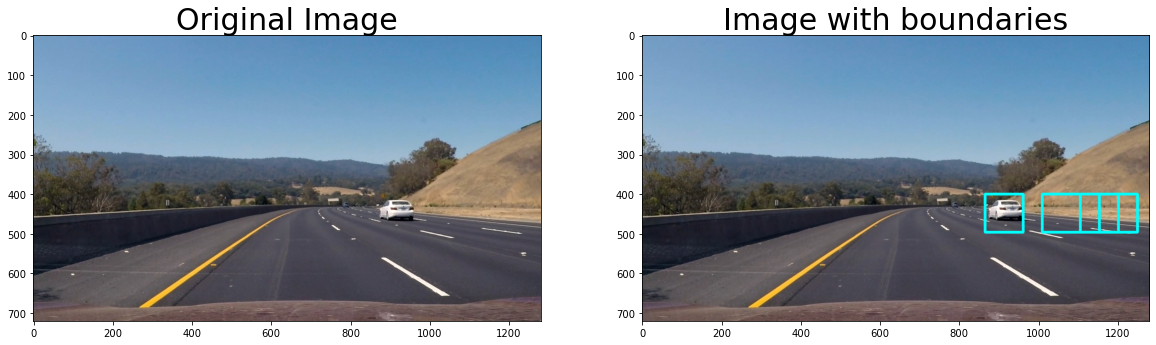

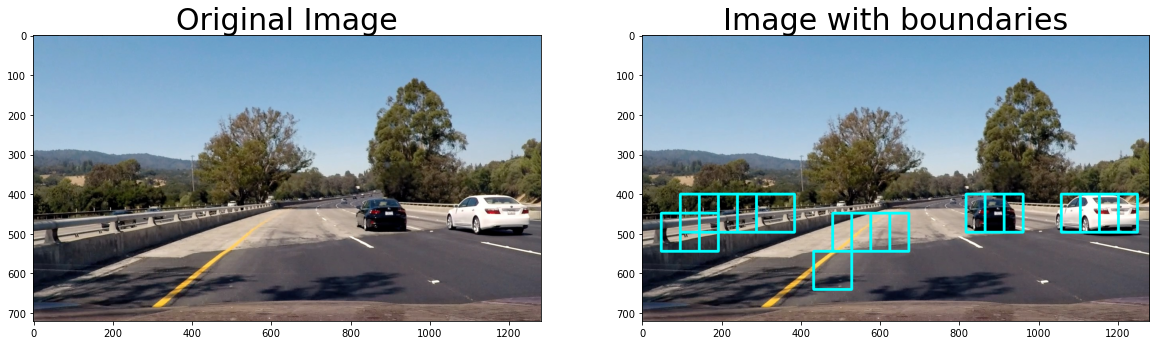

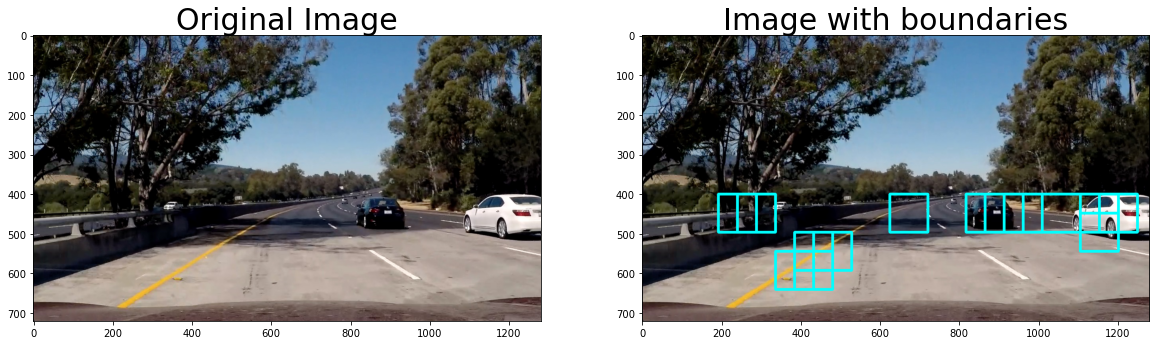

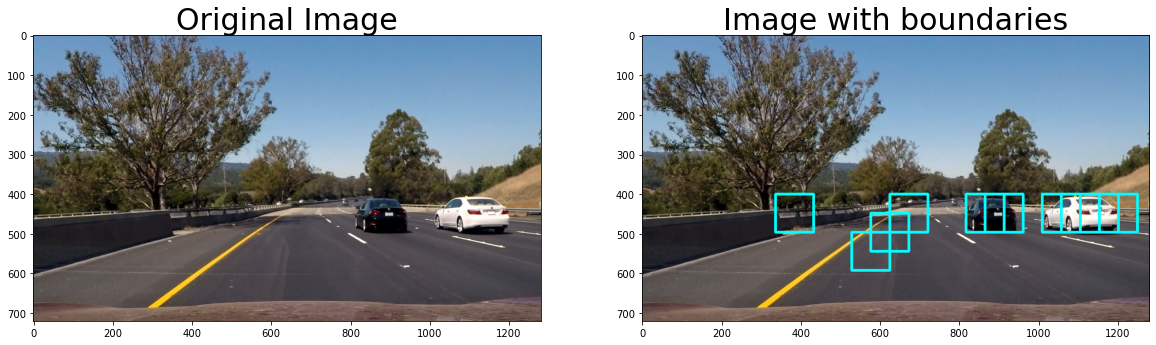

In [15]:
##Undistortion on a test image
images = glob.glob('test_images/test*.jpg')
for i, test_img in enumerate(images):
    test_img=matimg.imread(test_img)
    ystart = 400
    ystop = 656
    scale = 1.5
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    rectangle = findcar(test_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block)
    draw_img=draw_boxes(test_img, rectangle)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(test_img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(draw_img)
    ax2.set_title('Image with boundaries', fontsize=30)

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,255), 6)
    # Return the image
    return img

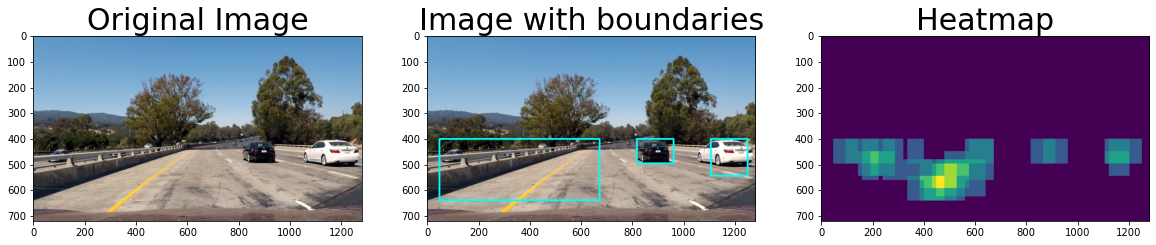

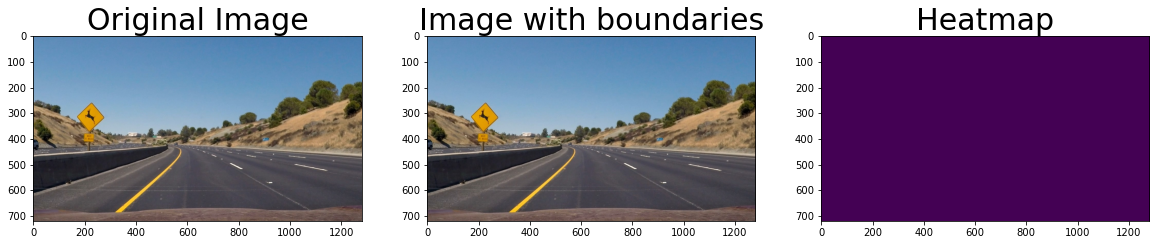

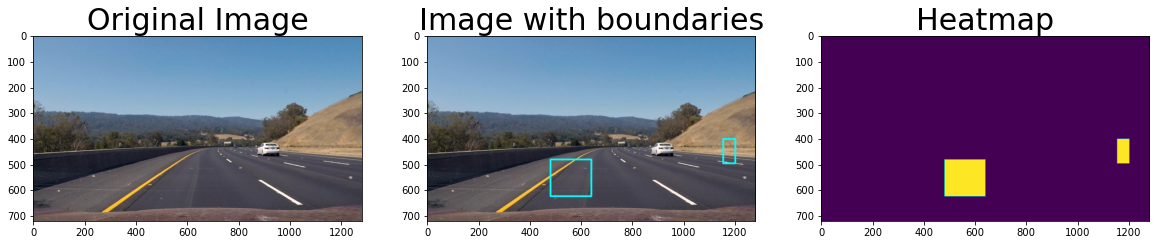

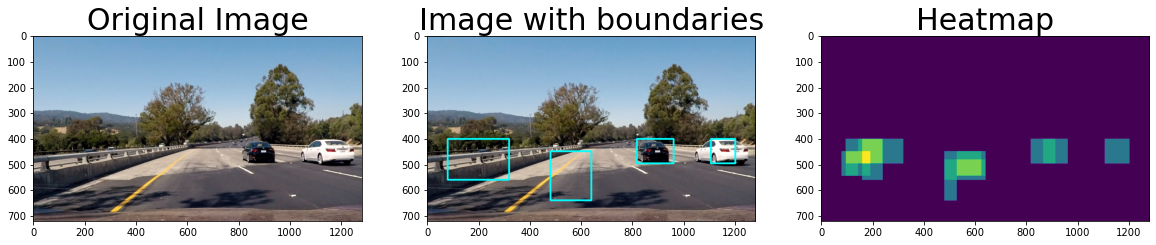

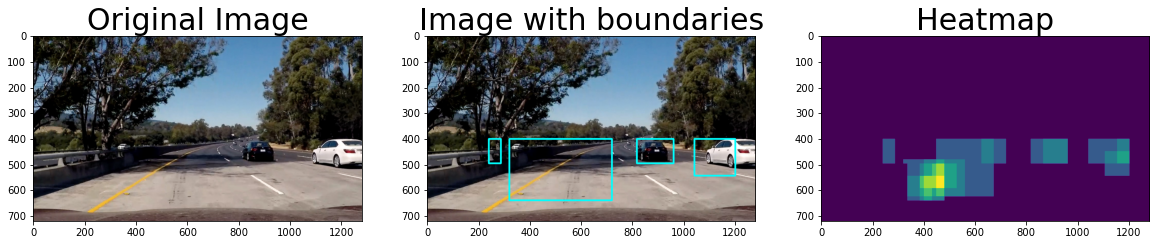

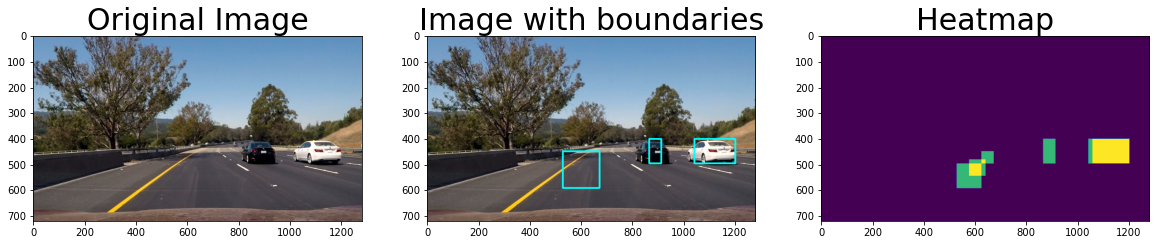

In [17]:
import itertools
from scipy.ndimage.measurements import label
##Undistortion on a test image
orient = 11
pix_per_cell = 16
cell_per_block = 2
images = glob.glob('test_images/test*.jpg')
for i, test_img in enumerate(images):
    test_img=matimg.imread(test_img)
    ystart = 400
    ystop = 656
    rectangle=[]
    for j in range(0,3):
        scale = j+1.5
        rectangle.append(findcar(test_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block))
    ##To flatten the list of lists 
    rectangle=list(itertools.chain.from_iterable(rectangle))
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heat=add_heat(heat, rectangle)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    #draw_img=draw_boxes(test_img, rectangle)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(test_img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(draw_img)
    ax2.set_title('Image with boundaries', fontsize=30)
    ax3.imshow(heatmap)
    ax3.set_title('Heatmap', fontsize=30)

In [18]:
##Creating Class to consider the previous rectangle
from collections import deque
class vehicle():
    def __init__(self):
        self.rects=deque(maxlen=10)
        self.prev_rect=[]
        self.frame=0

In [19]:
def pipeline(test_img):
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    ystart = 400
    ystop = 656
    rectangle=[]
    for j in range(0,4):
        scale = j+1.5
        rectangle.append(findcar(test_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block))
    ##To flatten the list of lists 
    rectangle=list(itertools.chain.from_iterable(rectangle))
    if rectangle==[] and detect.prev_rect!=[] and len(detect.rects)>5:
        rectangle=detect.prev_rect
    else: 
        detect.prev_rect=rectangle
    detect.rects.append(rectangle)
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    for rect in detect.rects:
        heat=add_heat(heat, rect)
    heat = apply_threshold(heat,1+len(detect.rects)//2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    #detect.frame+=1
    return draw_img

In [21]:
pip install moviepy

  Using cached moviepy-1.0.3.tar.gz (388 kB)
  Using cached proglog-0.1.9.tar.gz (10 kB)
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110732 sha256=c3209c95c525ba2120fce16cb23a8a482a41ca1c5848fc2a86587a7d4e5229a5
  Stored in directory: c:\users\vsanu\appdata\local\pip\cache\wheels\e4\a4\db\0368d3a04033da662e13926594b3a8cf1aa4ffeefe570cfac1
  Created wheel for proglog: filename=proglog-0.1.9-py3-none-any.whl size=6153 sha256=d59dbc2181d6a98454efcb3787945580eee3011111c92dacc9de3497c26f9744
  Stored in directory: c:\users\vsanu\appdata\local\pip\cache\wheels\22\82\ff\56950e4b223a69eda3a2bdeaef2ae4b274c3d1ced9b5814c99
Successfully built moviepy proglog
Note: you may need to restart the kernel to use updated packages.


In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
detect=vehicle()
white_output = "final-try1.mp4"
clip1 = VideoFileClip('project_video.mp4').subclip(22,26)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

In [24]:
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/100 [00:00<?, ?it/s, now=None]

Moviepy - Building video final-try1.mp4.
Moviepy - Writing video final-try1.mp4



Moviepy - Done !
Moviepy - video ready final-try1.mp4
Wall time: 24 s


In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
detect=vehicle()
white_output = "final1.mp4"
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

In [26]:
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video final1.mp4.
Moviepy - Writing video final1.mp4



Moviepy - Done !
Moviepy - video ready final1.mp4
Wall time: 4min 30s
